In [24]:
%matplotlib inline

import os
import psycopg2
import seaborn as sns
import pandas as pd
import random
import numpy as np
# from ggplot2 import *

import datetime
from matplotlib import pyplot as plt
from dateutil import relativedelta
from __future__ import division

from pymongo import MongoClient

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

os.sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from shared.coverage_charts import exploration
from shared.corr_charts import plot
from shared.fill_charts import plot_fill

## Log into PSQL
DB_NAME = os.environ['DB_NAME']
DB_HOST = os.environ['DB_HOST']
DB_USER = os.environ['DB_USER']
DB_PASS = os.environ['DB_PASS']
credentials = (DB_NAME, DB_USER, DB_HOST, DB_PASS)
psql = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s' options='-c statement_timeout=200000'" % credentials)

## Log into redshift. 
#RED_NAME = os.environ['REDSHIFT_NAME']
#RED_HOST = os.environ['REDSHIFT_HOST']
#RED_USER = os.environ['REDSHIFT_USER']
#RED_PASS = os.environ['REDSHIFT_PASS']
#RED_PORT = os.environ['REDSHIFT_PORT']
#r_credentials = (RED_NAME, RED_USER, RED_HOST, RED_PASS, RED_PORT)
#rpsql = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s' port='%s'" % r_credentials)

## Log into Mongo.
#USER = os.environ['MONGO_USER']
#PASS = os.environ['MONGO_PASS']
#HOST = os.environ['MONGO_HOST']
#DB = os.environ['MONGO_NAME']
#credentials = (USER, PASS, HOST, DB)


# Introduction
## Definition
- SPF (Sender Policy Framework) is an email authentication system that prevents sender **address** forgery.

- DKIM (DomainKeys Identified Mail) should be considered as a method to verify that the messages' **content** are trustworthy, meaning that they weren't changed from the moment the message left the initial mail server.

> This additional layer of trustability is achieved by an implementation of the standard public/private key signing process. Once again the owners of the domain add a DNS entry with the **public DKIM key** which will be used by receivers to verify that the message DKIM signature is correct, while on the sender side the server will sign the entitled mail messages with the corresponding private key.

- DMARC is a policy that applies clear instructions for the message receiver to follow if an email doesn't pass SPF or DKIM authentication - for instance, reject or junk it.

> * upon reception the receiving mail server checks if there is any existing DMARC policy published in the domain used by the SPF and/ or DKIM checks
* if *one or both* the SPF and DKIM checks succeed while still being *aligned* with the policy set by DMARC, then the check is considered successful, otherwise it's set as failed
* if the check fails, based on the action published by the DMARC policy, different actions are taken

## Something to Notice
* DKIM alone doesn't grant in any way that the sender server is allowed to send outgoing mail for the specific domain
* DMARC is still in its early age and not used as much as hoped to make a huge difference
* DMARC will break your email flow if you don't set up both SPF and DKIM before changing DMARC policy to anything above "none"

In [2]:
# Current year and month (used to get mappings and company info)
curr_year = 2018
curr_month = 6

curr_month_str = str(curr_month)
if len(curr_month_str) == 1:
    curr_month_str = '0' + curr_month_str 

In [5]:
# Loading data from psql or redshift
# dkim
query = 'SELECT * FROM clean_monthly_v3.email_dkim_agg WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
dkim = pd.read_sql_query(query, psql)

# dmarc
query = 'SELECT * FROM clean_monthly_v3.email_dmarc_agg WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
dmarc = pd.read_sql_query(query, psql)

# Explorations
## DKIM

### Step 1: Data
Check the structure of the table.

Metadata: https://cyence.atlassian.net/wiki/spaces/DS/pages/99633412/Data+ID+26+-+Email+DKIM

In [6]:
dkim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559106 entries, 0 to 559105
Data columns (total 8 columns):
run_date                 559106 non-null object
last_updated             559106 non-null object
cyence_id                559106 non-null int64
agg_cnt                  559106 non-null int64
total_records_cnt        559106 non-null int64
max_public_key_length    559106 non-null int64
min_public_key_length    559106 non-null int64
duration                 559106 non-null int64
dtypes: int64(6), object(2)
memory usage: 34.1+ MB


In [6]:
data.min_public_key_length.unique() # look at the data 

array([   0,  576,  640,  768,  896,  704,  832, 1088, 1152, 1472, 1216,
       1024, 1280,  960, 1344, 4928, 1792, 1856, 1536])

In [7]:
dkim.head()

,run_date,last_updated,cyence_id,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration
0,2018-06-01,2018-07-02,50771450,1,0,0,0,0
1,2018-06-01,2018-07-02,12000000304468,1,0,0,0,0
2,2018-06-01,2018-07-02,12000000304360,1,0,0,0,0
3,2018-06-01,2018-07-02,68734110,1,0,0,0,0
4,2018-06-01,2018-07-02,918534418,1,0,0,0,0


### Step 2: Distributions
#### total_records_cnt: the number of DKIMs found for websites associated with Cyence ID
505542/559106 (90%) Cyence IDs don't have valid DKIM records found.

In [13]:
total_records_cnt_tab = pd.crosstab(index = dkim['total_records_cnt'], columns = 'count')
total_records_cnt_tab
# total_records_cnt_tab/ total_records_cnt_tab.sum() # Look at percentage: more than 90% of data doesn't have records

col_0,count
total_records_cnt,
0,505542
1,50835
2,1952
3,393
4,159
5,76
6,47
7,24
8,21


#### Max_public_key_length& Min_public_key_length: 0 if no records
The statistics of these two variables should align with the `total_records_cnt` above. We created a column `public_key` to indicate whether a Cyence ID has public key or not, which is defined as
$$public\_key = \begin{cases}
1 &\text{max_public_key_length $\ne 0$ and min_public_key_length $\ne 0$}\\
0 &\text{otherwise}
\end{cases}$$

First of all, `max_public_key_length` and `min_public_key_length` should be zero at the same time if there's no record. It shows there are 505542 rows which is consistent with `total_records_cnt == 0`.

In [20]:
dkim[(dkim['max_public_key_length'] == 0)& (dkim['min_public_key_length'] == 0)].max_public_key_length.count()

505542

In [22]:
dkim["public_key"] = np.where((dkim["max_public_key_length"] != 0) & (dkim["min_public_key_length"] != 0), 1, 0)
dkim.public_key.value_counts()

0    505542
1     53564
Name: public_key, dtype: int64

#### public_key: an indicator of whether a Cyence ID has DKIM records or not

In [35]:
# Company Info
query = 'SELECT cyence_id, company_name, country, cyence_sector, sic4, revenue, income, employees FROM er.company_info WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
companies_info = pd.read_sql_query(query, psql)

# left join DKIM data with company info
new_dkim = pd.merge(dkim, companies_info, on = ["cyence_id", "cyence_id"], how = "left")

# Create revenue bins
new_dkim['revenue_bin'] = '<5M'
new_dkim.loc[(new_dkim['revenue'] >= 5) & (new_dkim['revenue'] < 10), 'revenue_bin'] = '5-10M'
new_dkim.loc[(new_dkim['revenue'] >= 10) & (new_dkim['revenue'] < 25), 'revenue_bin'] = '10-25M'
new_dkim.loc[(new_dkim['revenue'] >= 25) & (new_dkim['revenue'] < 50), 'revenue_bin'] = '25-50M'
new_dkim.loc[(new_dkim['revenue'] >= 50) & (new_dkim['revenue'] < 100), 'revenue_bin'] = '50-100M'
new_dkim.loc[(new_dkim['revenue'] >= 100) & (new_dkim['revenue'] < 500), 'revenue_bin'] = '100-500M'
new_dkim.loc[(new_dkim['revenue'] >= 500) & (new_dkim['revenue'] < 1000), 'revenue_bin'] = '500M-1B'
new_dkim.loc[(new_dkim['revenue'] >= 1000) & (new_dkim['revenue'] < 5000), 'revenue_bin'] = '1-5B'
new_dkim.loc[(new_dkim['revenue'] >= 5000) & (new_dkim['revenue'] < 10000), 'revenue_bin'] = '5-10B'
new_dkim.loc[new_dkim['revenue'] >= 10000, 'revenue_bin'] = '>10B'

new_dkim.head()

,run_date,last_updated,cyence_id,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration,public_key,company_name,country,cyence_sector,sic4,revenue,income,employees,revenue_bin
0,2018-06-01,2018-07-02,50771450,1,0,0,0,0,0,Brown and Brown Associates PC Inc,United States,Financial Services,6411,1.000000,0.000000,10.0,<5M
1,2018-06-01,2018-07-02,12000000304468,1,0,0,0,0,0,Greater Morgan County Buildersassociation,United States,Licensed Professional Services,1521,0.474000,NaN,1.0,<5M
2,2018-06-01,2018-07-02,12000000304360,1,0,0,0,0,0,Grazzini Brothers And Company,United States,Licensed Professional Services,1711,42.356000,NaN,200.0,25-50M
3,2018-06-01,2018-07-02,68734110,1,0,0,0,0,0,"Germek, L Heating & Cooling Inc",United States,Licensed Professional Services,1711,1.000000,0.000000,12.0,<5M
4,2018-06-01,2018-07-02,918534418,1,0,0,0,0,0,HINDUSTHAN ENGINEERING & INDUSTRIES LIMITED,India,Manufacturing,2819,0.097254,0.000766,1043.0,<5M


Create a heatmap to visualize the data by sector and revenue bin.

In [101]:
# heatmap
# Prepare data
plot_data = pd.DataFrame(new_dkim[new_dkim['public_key'] == 1].groupby(['cyence_sector', 'revenue_bin']).public_key.count()).reset_index()

# pivot the dataset to put revenue bins on x axis and sectors on y axis
plot_data = plot_data.pivot('cyence_sector', 'revenue_bin', 'public_key') 

sectors = sorted(new_dkim.cyence_sector.unique())[2: 19]
revenue_bins = ['<5M', '5-10M', '10-25M', '25-50M', '50-100M', '100-500M', '500M-1B', '1-5B', '5-10B', '>10B']

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text yticklabel objects>)

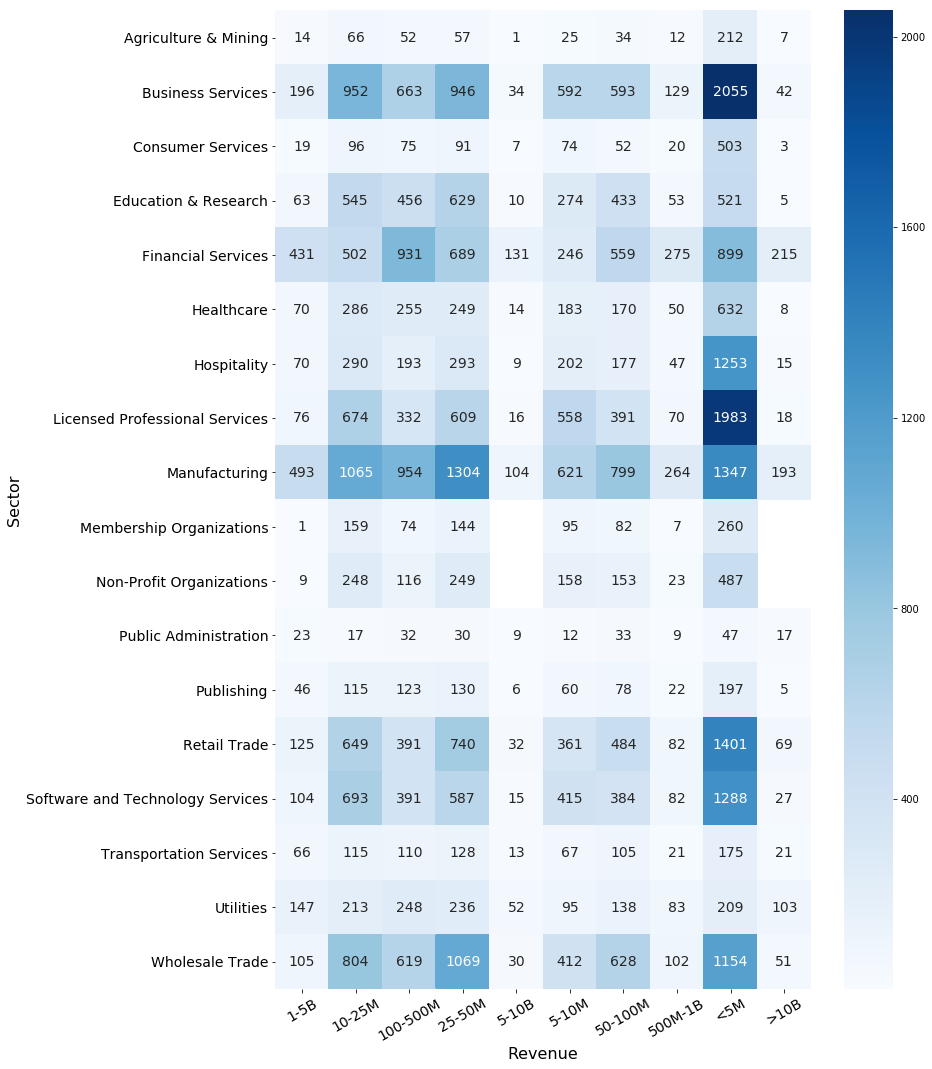

In [109]:
# plot
plt.figure(figsize = (12, 18))
sns.heatmap(plot_data, annot = True, cmap = 'Blues', fmt = 'g', annot_kws = {"size": 14})

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Sector", fontsize = 16)
plt.xticks(fontsize = 14, rotation = 30)
plt.yticks(fontsize = 14)

### Step 3: Outliers
#### Merge with Company Info

In [32]:
# Company Info
query = 'SELECT cyence_id, company_name, country, cyence_sector, sic4, revenue, income, employees FROM er.company_info WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
companies_info = pd.read_sql_query(query, psql)

# left join DKIM data with company info
new_dkim = pd.merge(dkim, companies_info, on = ["cyence_id", "cyence_id"], how = "left")
new_dkim.head()

KeyboardInterrupt: 

Left join two datasets:

In [30]:
# inner join DKIM data with company info
new_dkim = pd.merge(dkim, companies_info, on = ["cyence_id", "cyence_id"], how = "left")
new_dkim.head()

# new_data.agg_cnt.value_counts()

,run_date,last_updated,cyence_id,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration,public_key,company_name,country,cyence_sector,sic4,revenue,income,employees
0,2018-06-01,2018-07-02,50771450,1,0,0,0,0,0,Brown and Brown Associates PC Inc,United States,Financial Services,6411,1.000000,0.000000,10.0
1,2018-06-01,2018-07-02,12000000304468,1,0,0,0,0,0,Greater Morgan County Buildersassociation,United States,Licensed Professional Services,1521,0.474000,NaN,1.0
2,2018-06-01,2018-07-02,12000000304360,1,0,0,0,0,0,Grazzini Brothers And Company,United States,Licensed Professional Services,1711,42.356000,NaN,200.0
3,2018-06-01,2018-07-02,68734110,1,0,0,0,0,0,"Germek, L Heating & Cooling Inc",United States,Licensed Professional Services,1711,1.000000,0.000000,12.0
4,2018-06-01,2018-07-02,918534418,1,0,0,0,0,0,HINDUSTHAN ENGINEERING & INDUSTRIES LIMITED,India,Manufacturing,2819,0.097254,0.000766,1043.0


Top 2 outliers with `total_records_cnt` = 63 and 411.

In [31]:
new_dkim[(new_dkim['total_records_cnt'] == 63) | (new_dkim['total_records_cnt'] == 411)]

,run_date,last_updated,cyence_id,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration,public_key,company_name,country,cyence_sector,sic4,revenue,income,employees
357134,2018-06-01,2018-07-02,1024314,531,63,704,576,0,1,Berkshire Hathaway Inc.,United States,Financial Services,6719,223604.0,24074.0,367700.0
486932,2018-06-01,2018-07-02,12000000356942,9397,411,704,576,0,1,Hot Pie'S Pies,United Kingdom,Manufacturing,2111,1.0,NaN,1.0


Look at the distribution of main variables.

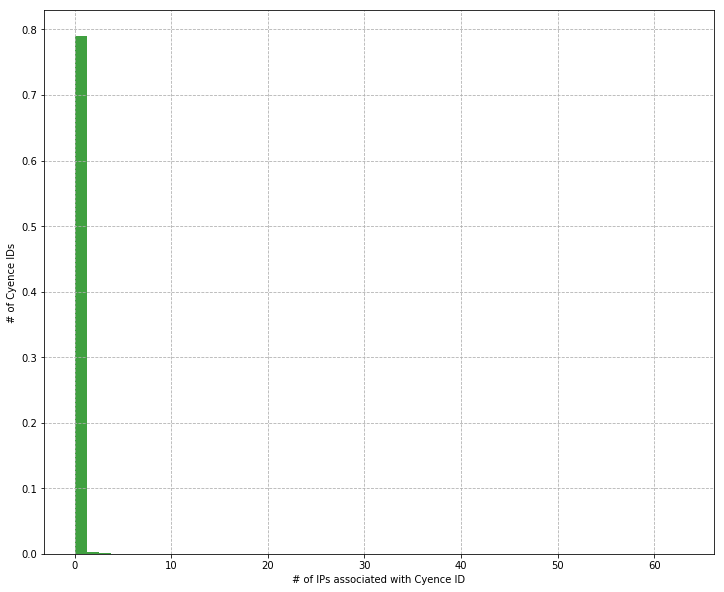

In [12]:
# the histogram of the data
plt.figure(figsize = (12, 10))
n, bins, patches = plt.hist(new_data['total_records_cnt'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('# of IPs associated with Cyence ID')
plt.ylabel('# of Cyence IDs')
# plt.title('Histogram of total_records_cnt')
plt.grid(ls = "--")
plt.show()

Look at the relationship between `total_records_cnt` (the number of DKIMs found for websites associated with cyence ID) and revenue (log scale).

**Conclusion:**

- There is no linear relationship between the two.
- Generally speaking, a larger company seems to have more DKIM records.

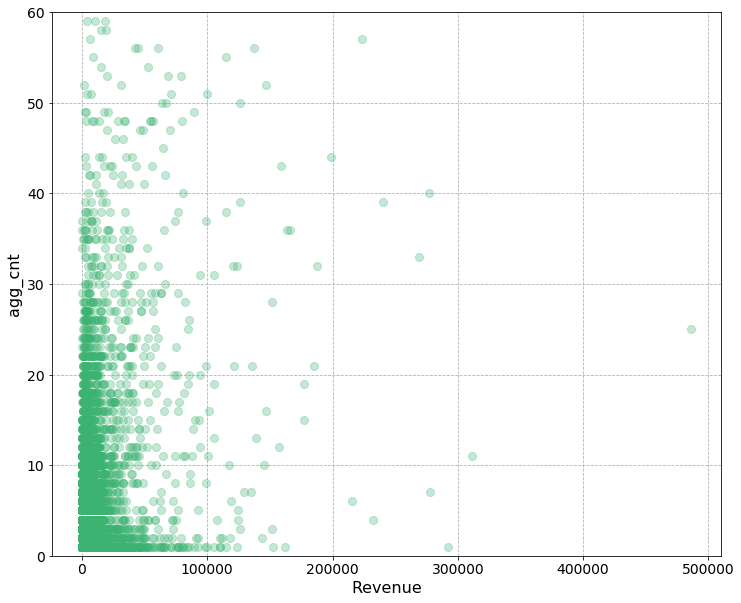

In [13]:
# Scatter plot
plt.figure(figsize = (12, 10))
# plt.plot(new_data['revenue'], new_data['agg_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 10)
plt.plot(new_data['revenue'] , new_data['agg_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 8)

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("agg_cnt", fontsize = 16) 
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim((0, 60))
plt.grid(ls = "--")

# plt.savefig("revenue_agg_cnt.png")

### Step 3: Coverage

In [14]:
# If data need to be aggregated from DUNS level
query = 'SELECT cyence_id, duns_key FROM get_mappings(\'%s-%s-01\');' % (str(curr_year), curr_month_str)
mappings = pd.read_sql_query(query, psql)
agg_data = pd.merge(mappings, new_data, on = ["cyence_id", "cyence_id"])

In [15]:
agg_data["public_key"] = np.where(agg_data["max_public_key_length"] != 0, 1, 0)
agg_data.public_key.value_counts()

0    575379
1    162804
Name: public_key, dtype: int64

Since most of the cyence_ids don't have a public_key, I tried to explore the relationship between the existance of public_key and the revenue_label, which potentially represents the company size. It turned out that there are more large companies with revenue greater than 1B having public keys.

In [17]:
sectors = agg_data.cyence_sector.unique()
d = {'sector': [], 'percent': [], 'n_cyenceIDs': [], 'n': []}

Then I decided to look at it by cyence sector, but I excluded small companies with revenue < 5M, among which most companies don't have DKIM public keys.

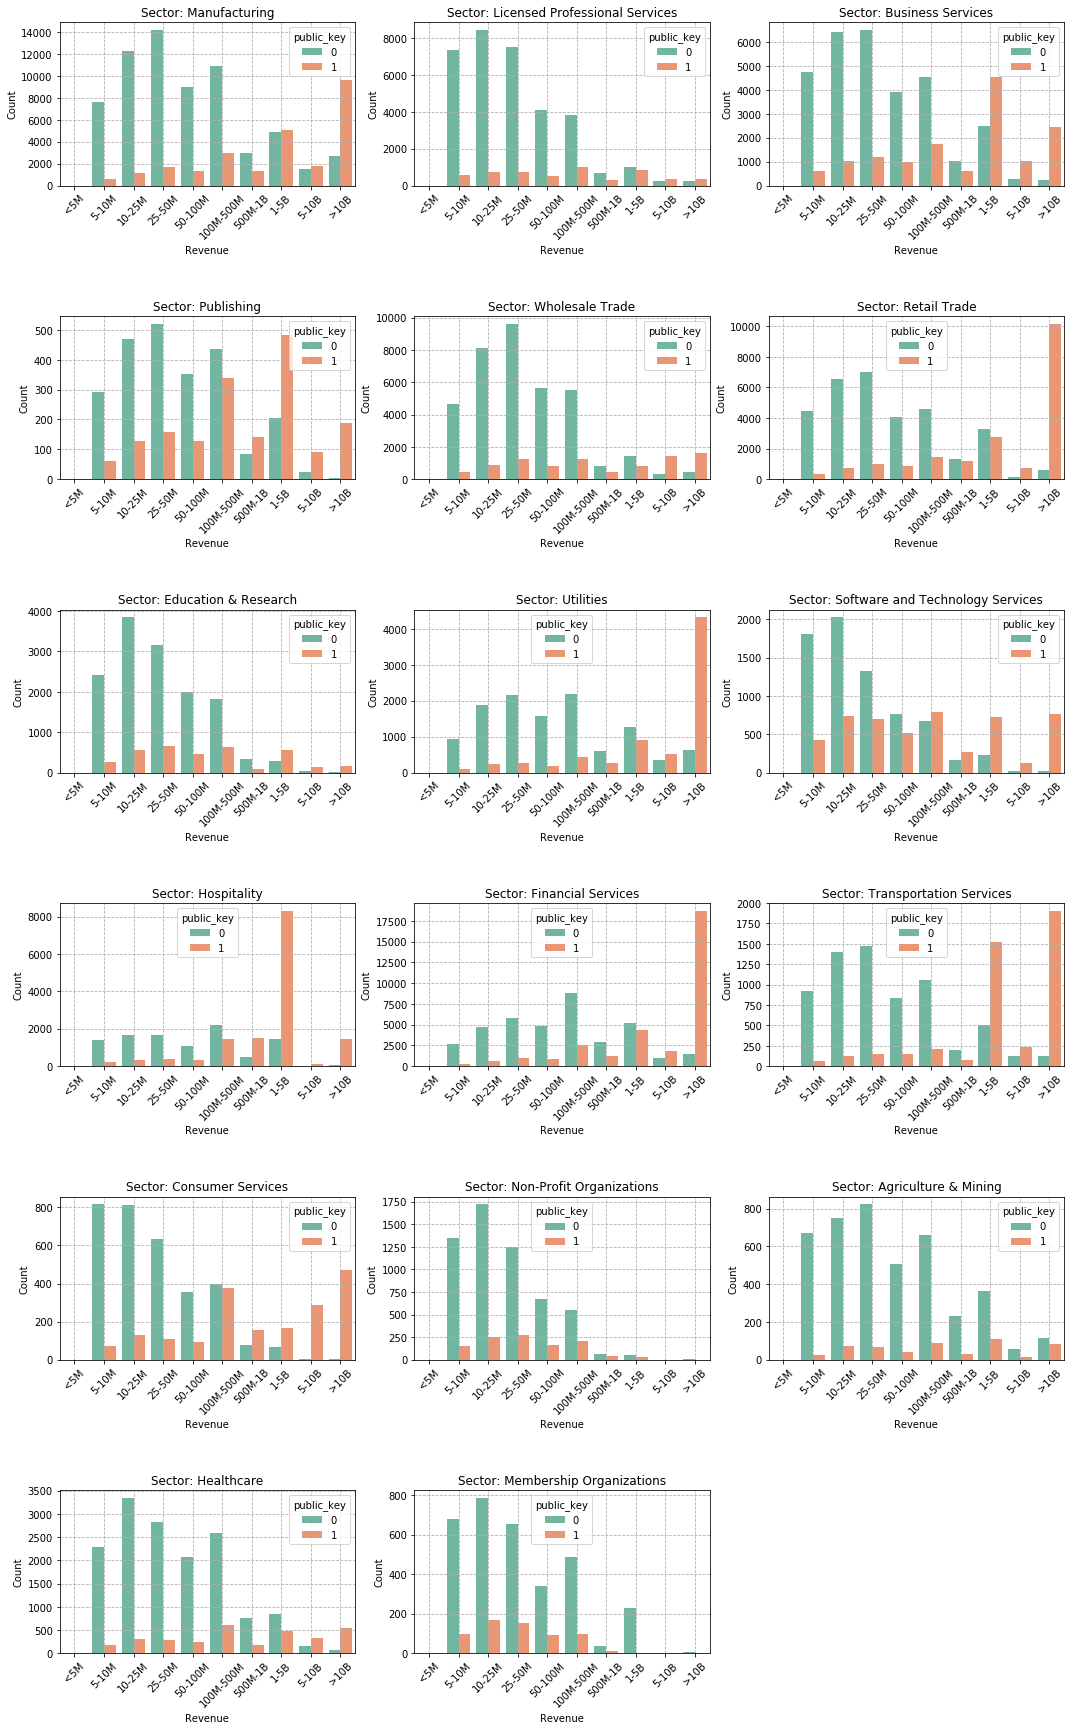

In [18]:
fig = plt.figure(figsize = (18, 30))
fig.subplots_adjust(hspace = 0.8)

for i in range(1, 18):
    ax = plt.subplot(6, 3, i)
    ax = sns.countplot(x = "revenue_label", hue = "public_key", data = agg_data.loc[(agg_data["cyence_sector"] == sectors[i]) & (agg_data["revenue_label"] != "<5M")], 
                   palette = sns.color_palette("Set2", n_colors=2))
    
    # settings
    plt.title("Sector: %s" % sectors[i])
    plt.xlabel("Revenue", fontsize = 10)
    plt.ylabel("Count", fontsize = 10)
    plt.xticks(fontsize = 10, rotation = 45)
    plt.yticks(fontsize = 10)
    plt.grid(ls = "--")

    d['sector'].append(sectors[i])
    d['percent'].append(agg_data.loc[(agg_data["cyence_sector"] == sectors[i]) & (agg_data['public_key'] == 1)].public_key.count()/ agg_data.loc[agg_data["cyence_sector"] == sectors[i]].public_key.count())
    d['n_cyenceIDs'].append(agg_data.loc[agg_data["cyence_sector"] == sectors[i]].public_key.count())
    d['n'].append(agg_data.loc[(agg_data["cyence_sector"] == sectors[i]) & (agg_data['public_key'] == 1)].public_key.count())
    
# plt.savefig('by_sector.png')

In [19]:
sector_percent = pd.DataFrame.from_dict(d).sort_values(by = ['percent'], ascending = False)
sector_percent = sector_percent[['sector', 'percent', 'n_cyenceIDs', 'n']]
sector_percent

,sector,percent,n_cyenceIDs,n
9,Hospitality,0.400718,38169,15295
10,Financial Services,0.380126,85006,32313
7,Utilities,0.336515,22213,7475
3,Publishing,0.317645,6013,1910
11,Transportation Services,0.290115,15973,4634
5,Retail Trade,0.264586,78088,20661
8,Software and Technology Services,0.236476,26730,6321
0,Manufacturing,0.221678,121690,26976
2,Business Services,0.210934,77285,16302
6,Education & Research,0.162285,25141,4080


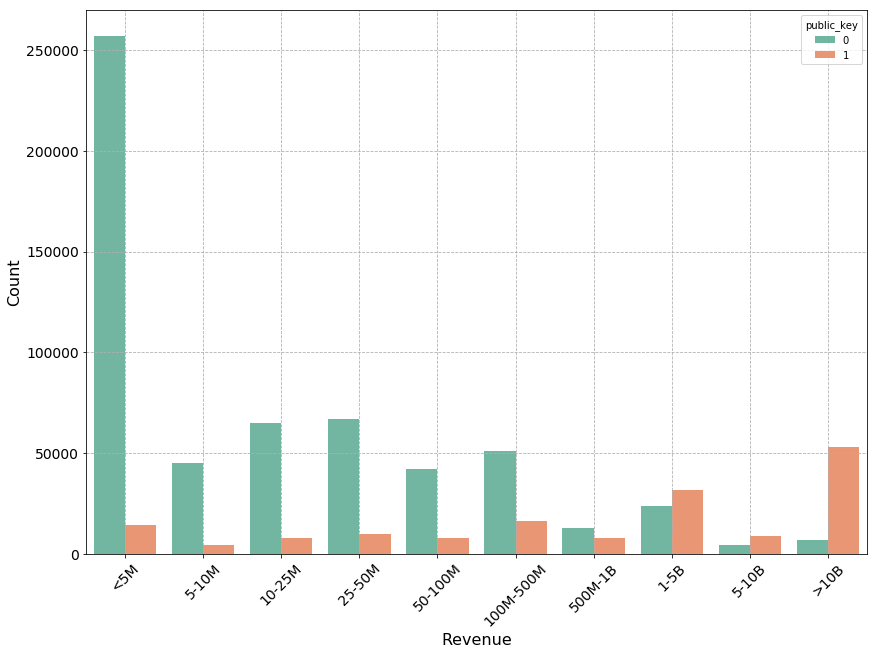

In [20]:
plt.figure(figsize = (14, 10))
ax = sns.countplot(x = "revenue_label", hue = "public_key", data = agg_data, 
                   palette = sns.color_palette("Set2", n_colors=2))

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)
plt.grid(ls = "--")

plt.savefig("public_key.png")

Scatter plot within the companies that have public keys. There seems to be no significant relationship between `revenue` and `max_public_key_length`. The top two outliers correspond to USPS (4928) and Paypal. 

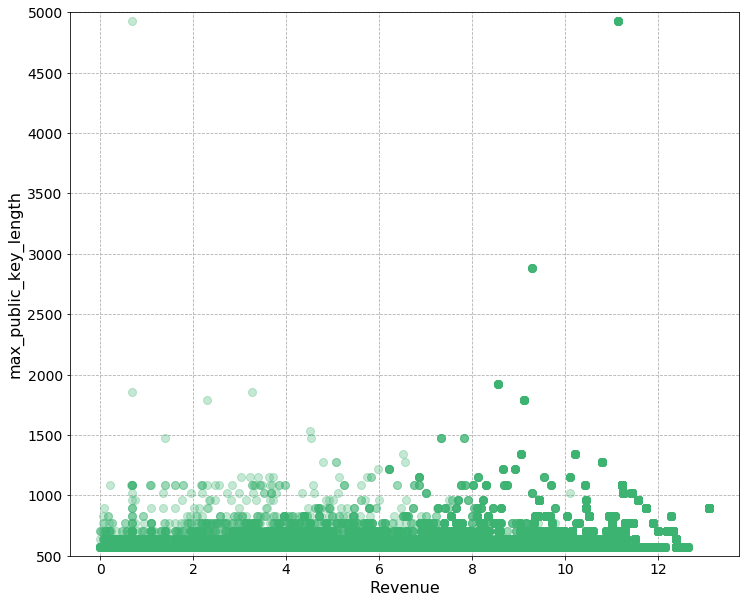

In [21]:
# Scatter plot
plt.figure(figsize = (12, 10))
temp_data = agg_data.loc[agg_data["public_key"] == 1]
# plt.plot(new_data['revenue'], new_data['agg_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 10)
plt.plot(np.log(temp_data['revenue'] + 1) , temp_data['max_public_key_length'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 8)

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("max_public_key_length", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim((500, 5000))
plt.grid(ls = "--")

In [133]:
# Check outliers: select company_name from er.company_info where cyence_id = 79809888;
agg_data.loc[(agg_data["public_key"] == 1) & (agg_data["max_public_key_length"] > 2000)]["cyence_id"].unique()

array([  3261245,  79809888, 797530243])

### Step 4: Correlation

In [22]:
# Create coverage plots
cyids_info, er_info = exploration.get_revenue_and_sector(data['cyence_id'].unique(), datetime.datetime(curr_year, curr_month, 1))

Retrieving ER information from company_info
Retrieving ER information from company_info_eu
Retrieving ER information from company_info_jp


In [24]:
exploration.create_breakdown_plots(cyids_info, er_info)

Creating the csvs..
Running the R plot scripts...
Could not execute R script:  Command '['RScript', '/Users/ygao/Desktop/Data Exploration/DKIM/shared/coverage_charts/CyidDistribution.R']' returned non-zero exit status 1


In [23]:
# Get correlation between variables- works best with <10
# Generates both Pearson and Spearman
plot.var_corr(agg_data)

Exception: Numeric columns only

In [ ]:
# Correlation with revenue, employee, sector
query = 'SELECT cyence_id, revenue, employees, cyence_sector FROM er.company_info \
         WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
company_info = pd.read_sql_query(query, psql)

In [ ]:
# corr_info should contain numerical columns (possibly including revenue, employees, IPs) and 
# one column for cyence_sector
corr_info = pd.merge(company_info, data_subset)
plot.make_corr_chart(corr_info.drop('cyence_id', 1))